<div align="Right">
    ![](images/ntt.jpg)
    <br>
    <br>
    **NTT Security, R&D Sweden<br>
  © NTT Security 2017<br>
    Josefin Axberg**<br>
 </div>

# Titanic: Machine Learning from Disaster

## Introduction

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In my first Kaggle-challenge, I am going to use the Titanic dataset to complete the analysis of what sorts of people were likely to survive. In particular, I am going to apply the tools of machine learning that I have learnt to predict which passengers survived the tragedy.

![](images/titanic.jpg)

In [205]:
import time
print("Today is %s" % time.strftime("%Y-%m-%d"))

Today is 2017-09-05


In [206]:
import os
import sys
import re


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.externals import joblib
from scipy.stats import randint as sp_randint
%matplotlib inline

from sklearn import ensemble
from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestRegressor

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import mlxtend

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split



from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Explore the data

In [207]:
# Load the train & test csv files as a DataFrame
titanic_train_df = pd.read_csv('data/train.csv')
titanic_test_df = pd.read_csv('data/test.csv')
combine = [titanic_train_df, titanic_test_df]

# Preview the data
titanic_train_df.head()
titanic_train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [208]:
# No. of passengers in the trainging set
len(titanic_train_df)

891

In [209]:
# Explore missing data
print(titanic_train_df.isnull().sum())
print(titanic_test_df.info())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


In [210]:
# Overview of the numerical variables
titanic_train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [211]:
# Mean of survived passengers per class
print (titanic_train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


In [212]:
# Mean of survived passengers per sex
print (titanic_train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


### Visualise the data

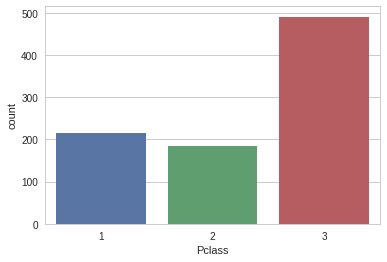

In [213]:
sns.countplot(titanic_train_df['Pclass'])

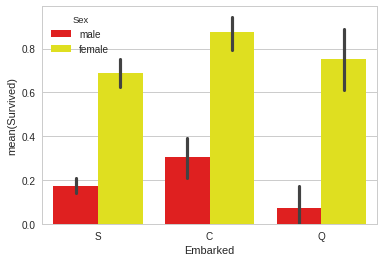

In [151]:
sns.set_style('whitegrid')
sns.barplot(x='Embarked', y='Survived', hue='Sex', data=titanic_train_df, palette={'male': 'red', 'female': 'yellow'})

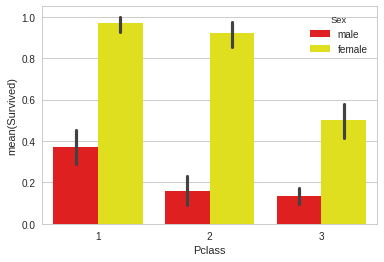

In [12]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_train_df, palette={"male": "red", "female": "yellow"})

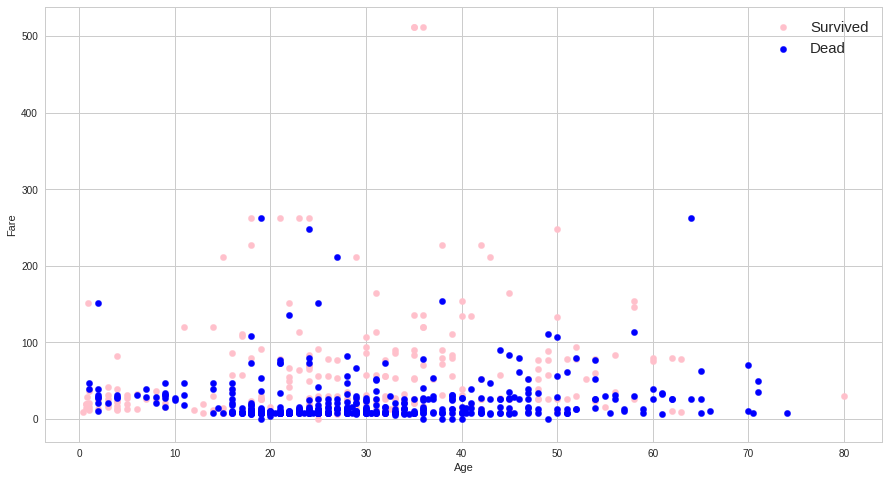

In [152]:
plt.figure(figsize=(15,8))
ax = plt.subplot()
ax.scatter(titanic_train_df[titanic_train_df['Survived']==1]['Age'],titanic_train_df[titanic_train_df['Survived']==1]['Fare'],c='pink',s=40)
ax.scatter(titanic_train_df[titanic_train_df['Survived']==0]['Age'],titanic_train_df[titanic_train_df['Survived']==0]['Fare'],c='blue',s=40)
ax.set_xlabel('Age')
ax.set_ylabel('Fare')
ax.legend(('Survived','Dead'),scatterpoints=1,loc='upper right',fontsize=15,)

## Feature Engineering

### Feature selection

In [214]:
# Feature selection, droping those columns that according to my human analysis won't be useful for prediction
titanic_train_df.drop(['PassengerId','Ticket','Fare'], axis=1,inplace=True)
titanic_test_df.drop(['Ticket','Fare'], axis=1,inplace=True)

titanic_train_df.head()
titanic_test_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,NaN,S


In [215]:
# Simplifying the features and avoids overfitting by grouping the people in logical age groups
titanic_train_df['Age_groups'] = pd.cut(titanic_train_df['Age'], [0, 5, 15, 30, 60, 80], labels=['Toddler', 'Child', 'Young Adult', 'Adult', 'Old'])
titanic_train_df.drop(['Age'], axis=1, inplace=True)

# The pure name does not seem relevant, lets extract the title to a new feature named "Titel"
titanic_train_df['Title'] = titanic_train_df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
titanic_train_df.drop(['Name'], axis=1,inplace=True)

# There is a lot of different "Titel"s but most of them are quite rare. Let us call them 'Rare'.
titanic_train_df['Title'] = titanic_train_df['Title'].replace(['Lady', 'the Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
titanic_train_df['Title'] = titanic_train_df['Title'].replace('Mlle', 'Miss')
titanic_train_df['Title'] = titanic_train_df['Title'].replace('Ms', 'Miss')
titanic_train_df['Title'] = titanic_train_df['Title'].replace('Mme', 'Mrs')

# The number of the cabin should not matter, but I belive the letter stands for "Deck", 
# lets extract the numbers in "Cabin" and replace the feature with a new one called "Deck"
titanic_train_df['Deck'] = titanic_train_df['Cabin'].str.replace('\d+', '')
titanic_train_df.drop(['Cabin'], axis=1, inplace=True)

# I replace "SibSp" and "Parch" with a new feature called "Familysize", due to 
titanic_train_df['Family_size'] = titanic_train_df['SibSp'] + titanic_train_df['Parch'] + 1
titanic_train_df.drop(['SibSp', 'Parch'], axis=1,inplace=True)

titanic_train_df.head()

,Survived,Pclass,Sex,Embarked,Age_groups,Title,Deck,Family_size
0,0,3,male,S,Young Adult,Mr,NaN,2
1,1,1,female,C,Adult,Mrs,C,2
2,1,3,female,S,Young Adult,Miss,NaN,1
3,1,1,female,S,Adult,Mrs,C,2
4,0,3,male,S,Adult,Mr,NaN,1


In [216]:
# I do the same as above but now with the test data
titanic_test_df['Age_groups'] = pd.cut(titanic_test_df['Age'], [0, 5, 15, 30, 60, 80], labels=['Toddler', 'Child', 'Young Adult', 'Adult', 'Old'])
titanic_test_df.drop(['Age'], axis=1, inplace=True)

titanic_test_df['Title'] = titanic_test_df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
titanic_test_df.drop(['Name'], axis=1,inplace=True)

titanic_test_df['Title'] = titanic_test_df['Title'].replace(['Lady', 'the Countess', 'Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
titanic_test_df['Title'] = titanic_test_df['Title'].replace('Mlle', 'Miss')
titanic_test_df['Title'] = titanic_test_df['Title'].replace('Ms', 'Miss')
titanic_test_df['Title'] = titanic_test_df['Title'].replace('Mme', 'Mrs')

titanic_test_df['Deck'] = titanic_test_df['Cabin'].str.replace('\d+', '')
titanic_test_df.drop(['Cabin'], axis=1, inplace=True)

titanic_test_df['Family_size'] = titanic_test_df['SibSp'] + titanic_test_df['Parch'] + 1
titanic_test_df.drop(['SibSp', 'Parch'], axis=1, inplace=True)

titanic_test_df.head()

,PassengerId,Pclass,Sex,Embarked,Age_groups,Title,Deck,Family_size
0,892,3,male,Q,Adult,Mr,NaN,1
1,893,3,female,S,Adult,Mrs,NaN,2
2,894,2,male,Q,Old,Mr,NaN,1
3,895,3,male,S,Young Adult,Mr,NaN,1
4,896,3,female,S,Young Adult,Mrs,NaN,3


In [217]:
#features = ['PassengerId','Pclass','Sex','Embarked','Age_groups','Title','Deck','Family_size']

In [218]:
# Fill NaN with the most statistical right value for "Deck" and "Age_groups"
titanic_train_df.loc[(titanic_train_df.Pclass == 1) & (titanic_train_df.Deck.isnull()), 'Deck'] = 'A'
titanic_train_df.loc[(titanic_train_df.Pclass == 2) & (titanic_train_df.Deck.isnull()), 'Deck'] = 'E'
titanic_train_df.loc[(titanic_train_df.Pclass == 3) & (titanic_train_df.Deck.isnull()), 'Deck'] = 'G'

titanic_test_df.loc[(titanic_test_df.Pclass == 1) & (titanic_test_df.Deck.isnull()), 'Deck'] = 'A'
titanic_test_df.loc[(titanic_test_df.Pclass == 2) & (titanic_test_df.Deck.isnull()), 'Deck'] = 'E'
titanic_test_df.loc[(titanic_test_df.Pclass == 3) & (titanic_test_df.Deck.isnull()), 'Deck'] = 'G'


titanic_train_df['Deck'] = titanic_train_df['Deck'].replace(['C C', 'C C C'], 'C')
titanic_train_df['Deck'] = titanic_train_df['Deck'].replace(['B B', 'B B B', 'B B B B'], 'B')
titanic_train_df['Deck'] = titanic_train_df['Deck'].replace(['D D','F E', 'F G'], 'D')

titanic_test_df['Deck'] = titanic_test_df['Deck'].replace(['C C', 'C C C'], 'C')
titanic_test_df['Deck'] = titanic_test_df['Deck'].replace(['B B', 'B B B', 'B B B B'], 'B')
titanic_test_df['Deck'] = titanic_test_df['Deck'].replace(['D D','F E', 'F G'], 'D')
titanic_test_df['Deck'] = titanic_test_df['Deck'].replace(['E E'], 'E')

titanic_train_df.loc[(titanic_train_df.Title == "Mr") & (titanic_train_df.Age_groups.isnull()), 'Age_groups'] = 'Adult'
titanic_train_df.loc[(titanic_train_df.Title == "Master") & (titanic_train_df.Age_groups.isnull()), 'Age_groups'] = 'Child'
titanic_train_df.loc[(titanic_train_df.Title == "Mrs") & (titanic_train_df.Age_groups.isnull()), 'Age_groups'] = 'Adult'
titanic_train_df.loc[(titanic_train_df.Title == "Miss") & (titanic_train_df.Age_groups.isnull()), 'Age_groups'] = 'Young Adult'
titanic_train_df.loc[(titanic_train_df.Title == "Rare") & (titanic_train_df.Age_groups.isnull()), 'Age_groups'] = 'Adult'

titanic_test_df.loc[(titanic_test_df.Title == "Mr") & (titanic_test_df.Age_groups.isnull()), 'Age_groups'] = 'Adult'
titanic_test_df.loc[(titanic_test_df.Title == "Master") & (titanic_test_df.Age_groups.isnull()), 'Age_groups'] = 'Child'
titanic_test_df.loc[(titanic_test_df.Title == "Mrs") & (titanic_test_df.Age_groups.isnull()), 'Age_groups'] = 'Adult'
titanic_test_df.loc[(titanic_test_df.Title == "Miss") & (titanic_test_df.Age_groups.isnull()), 'Age_groups'] = 'Young Adult'
titanic_test_df.loc[(titanic_test_df.Title == "Rare") & (titanic_test_df.Age_groups.isnull()), 'Age_groups'] = 'Adult'

titanic_train_df.head()
titanic_test_df.head()

,Survived,Pclass,Sex,Embarked,Age_groups,Title,Deck,Family_size
0,0,3,male,S,Young Adult,Mr,G,2
1,1,1,female,C,Adult,Mrs,C,2
2,1,3,female,S,Young Adult,Miss,G,1
3,1,1,female,S,Adult,Mrs,C,2
4,0,3,male,S,Adult,Mr,G,1


,PassengerId,Pclass,Sex,Embarked,Age_groups,Title,Deck,Family_size
0,892,3,male,Q,Adult,Mr,G,1
1,893,3,female,S,Adult,Mrs,G,2
2,894,2,male,Q,Old,Mr,E,1
3,895,3,male,S,Young Adult,Mr,G,1
4,896,3,female,S,Young Adult,Mrs,G,3


In [219]:
# Remaining NaN's
print(titanic_train_df.isnull().sum())
print(titanic_test_df.isnull().sum())

Survived       0
Pclass         0
Sex            0
Embarked       2
Age_groups     0
Title          0
Deck           0
Family_size    0
dtype: int64
PassengerId    0
Pclass         0
Sex            0
Embarked       0
Age_groups     0
Title          0
Deck           0
Family_size    0
dtype: int64


In [220]:
titanic_train_df = titanic_train_df.dropna(axis=0)
titanic_test_df = titanic_test_df.dropna(axis=0)

In [221]:
# Remaining NaN's after drop
print(titanic_train_df.isnull().sum())
print(titanic_test_df.isnull().sum())

Survived       0
Pclass         0
Sex            0
Embarked       0
Age_groups     0
Title          0
Deck           0
Family_size    0
dtype: int64
PassengerId    0
Pclass         0
Sex            0
Embarked       0
Age_groups     0
Title          0
Deck           0
Family_size    0
dtype: int64


In [222]:
# Mapping Sex
titanic_train_df['Sex'] = titanic_train_df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
titanic_test_df['Sex'] = titanic_test_df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

# Mapping Embarked
#embarked_mapping = {'S': 0, 'C': 1, 'Q': 2}
#titanic_train_df['Embarked'] = titanic_train_df['Embarked'].map(embarked_mapping)
#titanic_test_df['Embarked'] = titanic_test_df['Embarked'].map(embarked_mapping)

# Mapping Age_groups
agegroup_mapping = {'Toddler': 1, 'Child': 2,'Young Adult': 3, 'Adult': 4, 'Old': 5}
titanic_train_df['Age_groups'] = titanic_train_df['Age_groups'].map(agegroup_mapping)
titanic_test_df['Age_groups'] = titanic_test_df['Age_groups'].map(agegroup_mapping)

# Mapping Titles
#title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
#titanic_train_df['Title'] = titanic_train_df['Title'].map(title_mapping)
#titanic_test_df['Title'] = titanic_test_df['Title'].map(title_mapping)
                                 
# Mapping Deck
#deck_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7}
#titanic_train_df['Deck'] = titanic_train_df['Deck'].map(deck_mapping)
#titanic_test_df['Deck'] = titanic_test_df['Deck'].map(deck_mapping)

/home/josefin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/josefin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [223]:
titanic_train_df.head()
titanic_test_df.head()

,Survived,Pclass,Sex,Embarked,Age_groups,Title,Deck,Family_size
0,0,3,1,S,3,Mr,G,2
1,1,1,0,C,4,Mrs,C,2
2,1,3,0,S,3,Miss,G,1
3,1,1,0,S,4,Mrs,C,2
4,0,3,1,S,4,Mr,G,1


,PassengerId,Pclass,Sex,Embarked,Age_groups,Title,Deck,Family_size
0,892,3,1,Q,4,Mr,G,1
1,893,3,0,S,4,Mrs,G,2
2,894,2,1,Q,5,Mr,E,1
3,895,3,1,S,3,Mr,G,1
4,896,3,0,S,3,Mrs,G,3


## Evaluation Classifiers

### Algorithms on train/test data

In [224]:
# Convert strings to ints in training data
cols_to_transform = ['Embarked','Title', 'Deck']
titanic_train_df = pd.get_dummies(titanic_train_df, columns = cols_to_transform)
titanic_train_df.head()

,Survived,Pclass,Sex,Age_groups,Family_size,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,...,Title_Mrs,Title_Rare,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,0,3,1,3,2,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,1,0,4,2,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,1,3,0,3,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1,1,0,4,2,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
4,0,3,1,4,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [225]:
titanic_train_df = titanic_train_df.drop(['Deck_T'], axis=1)
titanic_train_df.head()

,Survived,Pclass,Sex,Age_groups,Family_size,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G
0,0,3,1,3,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
1,1,1,0,4,2,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,1,3,0,3,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
3,1,1,0,4,2,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
4,0,3,1,4,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1


In [226]:
# Convert strings to ints in test data
cols_to_transform = ['Embarked', 'Title', 'Deck']
titanic_test_df = pd.get_dummies(titanic_test_df, columns = cols_to_transform )
titanic_test_df.head()

,PassengerId,Pclass,Sex,Age_groups,Family_size,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G
0,892,3,1,4,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
1,893,3,0,4,2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
2,894,2,1,5,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
3,895,3,1,3,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
4,896,3,0,3,3,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1


In [227]:
# Get data in shape
X_train = titanic_train_df.drop("Survived", axis=1)
Y_train = titanic_train_df["Survived"]
X_test  = titanic_test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape    

((889, 19), (889,), (418, 19))

In [229]:
# Randomforest
clf_rf = RFC(n_estimators=100)
clf_rf.fit(X_train, Y_train)
Y_pred = clf_rf.predict(X_test)
clf_rf.score(X_train, Y_train)
accuracy_rf = clf_rf.score(X_train, Y_train) * 100
accuracy_rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

0.88188976377952755

88.188976377952756

### Improve the best Classifier (rf_clf)

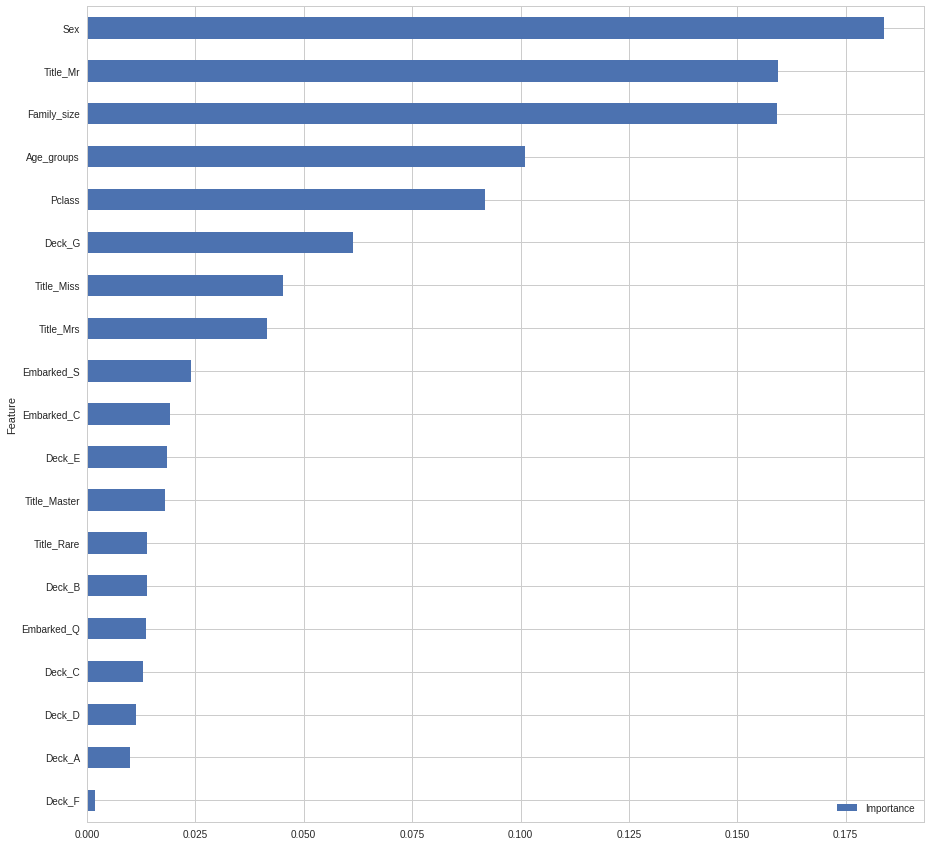

In [230]:
# Feature Importance
features = pd.DataFrame()
features['Feature'] = X_test.columns
features['Importance'] = clf_rf.feature_importances_
features.sort_values(by=['Importance'], ascending=True, inplace=True)
features.set_index('Feature', inplace=True)



features.plot(kind='barh', figsize=(15, 15))

In [231]:
X_train_mtrx =  X_train.as_matrix()

In [ ]:
# Sequential Feature Selector
sfs1 = SFS(clf_rf, 
           k_features=19, 
           forward=True, 
           floating=False,
           verbose = 2,
           scoring='accuracy',
           cv=0)

sfs1 = sfs1.fit(X_train_mtrx, Y_train)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.8s finished

[2017-09-05 16:05:12] Features: 1/19 -- score: 0.786276715411[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.5s finished

[2017-09-05 16:05:15] Features: 2/19 -- score: 0.803149606299[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    2.5s finished

[2017-09-05 16:05:17] Features: 3/19 -- score: 0.831271091114[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.5s finished

[2017-09-05 16:05:20] Features: 4/19 -- score: 0.843644544432[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.3s finished

[

In [108]:
# SFS with Gridsearch
sfs1 = SFS(estimator=clf_rf, 
           k_features=19,
           forward=True, 
           floating=False, 
           scoring='accuracy',
           cv=5)

pipe = Pipeline([('sfs', sfs1), 
                 ('clf_rf', clf_rf)])

param_grid = [
  {'sfs__k_features': [1, 2, 3, 4],
   'sfs__estimator__n_neighbors': [1, 2, 3, 4]}
  ]


gs = GridSearchCV(estimator=pipe, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  n_jobs=1, 
                  cv=5,  
                  refit=False)

# Run Gridsearch
gs = gs.fit(X_train_mtrx, Y_train)

ValueError: Invalid parameter n_neighbors for estimator RandomForestClassifier. Check the list of available parameters with `estimator.get_params().keys()`.

### ROC curve

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

ROC AUC: 0.90


(0.0, 1.0)

(0.0, 1.05)

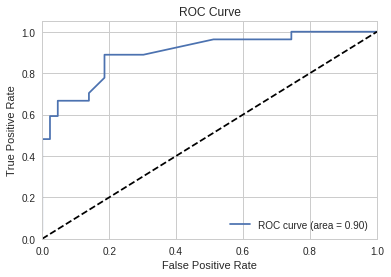

In [177]:
# Shuffle and split training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=.25)
clf_rf.fit(X_train, Y_train)
 
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(Y_test, clf_rf.predict_proba(X_test)[:,1])
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print ('ROC AUC: %0.2f' % roc_auc)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Run the improved Random forest model

In [189]:
# Randomforest improved
clf_rf = RFC(n_estimators=50)
clf_rf.fit(X_train, Y_train)
Y_pred = clf_rf.predict(X_test)
clf_rf.score(X_train, Y_train)
accuracy_rf = clf_rf.score(X_train, Y_train) * 100
accuracy_rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

0.90952380952380951

90.952380952380949

In [190]:
# Save improvment to output 
output = clf_rf.predict(titanic_test_df).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv('/data/test.csv')
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('/data/submission.csv',index=False)

ValueError: Number of features of the model must match the input. Model n_features is 19 and input n_features is 20 

In [204]:
submission = pd.DataFrame({
        "PassengerId": titanic_test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('../output/submission.csv', index=False)


ValueError: array length 70 does not match index length 418